In [3]:
!pip install gym==0.19.0

     |████████████████████████████████| 1.6 MB 8.3 MB/s 
  Created wheel for gym: filename=gym-0.19.0-py3-none-any.whl size=1663112 sha256=cf1acd6d0d65604c9f68f4f4a3030424e3c068414f4bc88948334180e9eaede2
  Stored in directory: /root/.cache/pip/wheels/ef/9d/70/8bea53f7edec2fdb4f98d9d64ac9f11aea95dfcb98099d7712
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [4]:
import random

import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

env = gym.make('Copy-v0')
actions = [(0, 0, 0),
           (0, 0, 1),
           (0, 0, 2),
           (0, 0, 3),
           (0, 0, 4),
           (0, 1, 0),
           (0, 1, 1),
           (0, 1, 2),
           (0, 1, 3),
           (0, 1, 4),
           (1, 0, 0),
           (1, 0, 1),
           (1, 0, 2),
           (1, 0, 3),
           (1, 0, 4),
           (1, 1, 0),
           (1, 1, 1),
           (1, 1, 2),
           (1, 1, 3),
           (1, 1, 4)]

In [5]:
# constants
EPSILON = 0.04
ALPHA = 0.001
GAMMA = 0.9

In [6]:
print('State:', env.observation_space)
print('Action:', env.action_space)
print('Num actions:', len(actions))

State: Discrete(6)
Action: Tuple(Discrete(2), Discrete(2), Discrete(5))
Num actions: 20


In [7]:
enc_state = OneHotEncoder()
X = np.array([0,1,2,3,4,5]).reshape(-1,1)
enc_state.fit(X)

enc_action_pred = OneHotEncoder()
Y = np.array([0,1,2,3,4]).reshape(-1,1)
enc_action_pred.fit(Y)

OneHotEncoder()

In [8]:
# initial state
# for each action:
#   compute features from (state, action)
#   forward pass features
#   output is single q value
# taken: max(q_vals) or random action

def make_input(state, action):
    state_enc = enc_state.transform(np.array([state]).reshape(-1, 1)).toarray()[0]
    pred_enc = enc_action_pred.transform(np.array([action[2]]).reshape(-1, 1)).toarray()[0]
    return np.matrix(np.concatenate((state_enc, [action[0], action[1]], pred_enc)))

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(13,)),
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer=initializers.he_normal()),
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer=initializers.he_normal()),
    # tf.keras.layers.Dense(25, activation='relu', kernel_initializer=initializers.he_normal()),
    tf.keras.layers.Dense(1, activation='linear', kernel_initializer=initializers.zeros())
])

In [10]:
all_episode_rewards = []
all_ep_avg_rewards = []
all_td_errors = []
all_timesteps = []

# plot how q vals change over time for each state,action in dictionary
all_q = {}

for i in range(500):
    observation = env.reset()
    episode_reward = 0
    episode_td_error = 0
    ep_avg_reward = 0
    if len(all_q) > 119:
      print('Converged', len(all_q))

    for j in range(20):
        with tf.GradientTape() as tape:
            rand = random.random()
            if rand < EPSILON:
                action = env.action_space.sample()
            else:
                q_vals = []
                # get max q value of actions from the current state
                for poss_action in actions:
                    est_val = model(make_input(observation, poss_action))
                    try:
                      all_q[tuple([observation, poss_action[0], poss_action[1], 
                                   poss_action[2]])].append(est_val)
                    except KeyError:
                      all_q[tuple([observation, poss_action[0], poss_action[1], 
                                   poss_action[2]])] = []

                    q_vals.append(est_val)

                best_idx = np.argmax(q_vals)
                action = actions[best_idx]
                # print('Q vals:', q_vals)
                # print(f'Action taken: {action} with index {best_idx}')

            next_state, reward, done, info = env.step(action)
            # reward shaping to prevent skipping
            # if reward == 0:
            #   reward = -0.02

            # obtain next best q value
            if done:
                max_next_q = 0
                print(f'Episode {i} finished after {j} timesteps')
                # average reward per action
                ep_avg_reward = ep_avg_reward / j if j != 0 else 0
                break
            else:
                next_q_vals = []
                for next_action in actions:
                    next_q_vals.append(tf.stop_gradient(model(make_input(next_state, next_action))))
                max_next_q = max(next_q_vals)

            # perform updates
            curr_q = model(make_input(observation, action))
            observed_q = reward + (GAMMA * max_next_q)
            td_err = (observed_q - curr_q) ** 2

            # apply gradients
            grads = tape.gradient(td_err, model.trainable_variables)
            opt = tf.keras.optimizers.Adam(learning_rate=ALPHA)
            opt.apply_gradients(zip(grads, model.trainable_variables))

            episode_td_error += td_err[0]
            episode_reward += reward
            ep_avg_reward += reward
            observation = next_state

    all_episode_rewards.append(episode_reward)
    all_td_errors.append(episode_td_error) 
    all_ep_avg_rewards.append(ep_avg_reward)
    all_timesteps.append(j)



Episode 0 finished after 12 timesteps
Episode 1 finished after 2 timesteps
Episode 2 finished after 3 timesteps
Episode 3 finished after 10 timesteps
Episode 4 finished after 8 timesteps
Episode 5 finished after 1 timesteps
Episode 6 finished after 0 timesteps
Episode 7 finished after 0 timesteps
Episode 8 finished after 0 timesteps
Episode 9 finished after 1 timesteps
Converged 120
Episode 10 finished after 0 timesteps
Converged 120
Episode 11 finished after 1 timesteps
Converged 120
Episode 12 finished after 0 timesteps
Converged 120
Episode 13 finished after 0 timesteps
Converged 120
Episode 14 finished after 0 timesteps
Converged 120
Episode 15 finished after 1 timesteps
Converged 120
Episode 16 finished after 2 timesteps
Converged 120
Episode 17 finished after 1 timesteps
Converged 120
Episode 18 finished after 0 timesteps
Converged 120
Episode 19 finished after 0 timesteps
Converged 120
Episode 20 finished after 0 timesteps
Converged 120
Episode 21 finished after 0 timesteps
Conv

ValueError: ignored

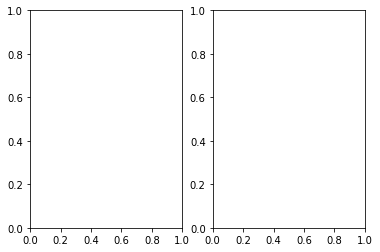

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(all_q[tuple([0, 1, 1, 0])], label='(1,1,0)')
ax1.plot(all_q[tuple([0, 1, 0, 0])], label='(1,0,0)')
ax1.set_title('Prediction: A')
# ax1.set_ylim([-2, ymax])
ax2.plot(all_q[tuple([0, 1, 1, 4])], label='(1,1,4)')
ax2.plot(all_q[tuple([0, 1, 0, 4])], label='(1,0,4)')
ax2.set_title('Prediction: E')
# ax2.set_ylim([ymin, ymax])
fig.suptitle('Comparing q-values between writing to output/not from state A')
plt.legend()

plt.show()

ValueError: ignored

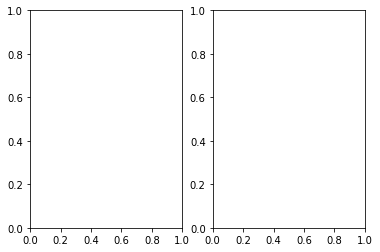

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(all_q[tuple([4, 1, 1, 0])], label='(1,1,0)')
ax1.plot(all_q[tuple([4, 1, 0, 0])], label='(1,0,0)')
ax1.set_title('Prediction: A')
# ax1.set_ylim([-2, ymax])
ax2.plot(all_q[tuple([4, 1, 1, 4])], label='(1,1,4)')
ax2.plot(all_q[tuple([4, 1, 0, 4])], label='(1,0,4)')
ax2.set_title('Prediction: E')
# ax2.set_ylim([ymin, ymax])
fig.suptitle('Comparing q-values between writing to output/not from state E')
plt.legend()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 1.0, 'TD-error over time')

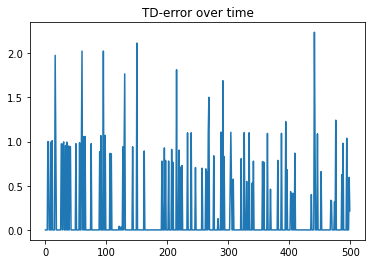

In [13]:
plt.plot(all_td_errors)
plt.title('TD-error over time')

In [ ]:
import json
with open('always_skipping_e_pred_optimal.txt', 'w') as convert_file:
     convert_file.write(json.dumps(str(all_q)))

In [242]:
# Obtain the optimal policy and q-values

policy = []
all_qs = []
bestAction = None
for state in range(6):
    bestQVal = float('-inf')
    for action in actions:
        # getting qVal by making forward pass through trained network
        qVal = model(make_input(state, action))
        all_qs.append(qVal.numpy()[0][0])
        # print(qVal.numpy())
        if qVal > bestQVal:
            bestAction = action
            bestQVal = qVal
    # print('Best q:', bestQVal)
    policy.append(bestAction)

print(policy)
print(all_qs)


[(0, 1, 2), (1, 1, 2), (0, 1, 2), (0, 1, 2), (0, 1, 2), (0, 1, 2)]
[0.22529308, 0.39522344, 0.48766786, 0.2334379, 0.26867032, 0.40223393, 0.5562819, 0.7135129, 0.29990435, 0.47941425, 0.278694, 0.35692355, 0.47651666, 0.23226018, 0.29372734, 0.4283595, 0.54264355, 0.68503153, 0.31691635, 0.48038983, 0.26855624, 0.38620344, 0.50792354, 0.18315287, 0.31789976, 0.35911775, 0.5617494, 0.6593013, 0.23545283, 0.47297052, 0.33834282, 0.44206944, 0.5347153, 0.25114918, 0.34723657, 0.443476, 0.5832757, 0.66544867, 0.33089584, 0.5248121, 0.31724387, 0.50660324, 0.5959419, 0.33703285, 0.25497228, 0.4361443, 0.68139803, 0.79639554, 0.39886773, 0.47209683, 0.33054158, 0.48473117, 0.5523467, 0.30339277, 0.2397273, 0.46610454, 0.68316114, 0.7520833, 0.42491335, 0.4565534, 0.1891317, 0.44606534, 0.502043, 0.20178923, 0.23397115, 0.31609306, 0.5822743, 0.64060116, 0.28891394, 0.3918978, 0.28000957, 0.42941186, 0.50359046, 0.2668928, 0.2661128, 0.32589555, 0.5985143, 0.6237984, 0.31836367, 0.41117123, 

In [214]:
# Use the model to visualize games

import time
for i_episode in range(3):
    observation = env.reset()
    print(observation)
    for t in range(15):
        env.render()
        time.sleep(0.5)
        bestQVal = float('-inf')
        for act in actions:
            # getting qVal by making forward pass through trained network
            qVal = model(make_input(observation, act))
            # print(qVal.numpy())
            if qVal > bestQVal:
                bestAction = act
                bestQVal = qVal
        action = bestAction
        observation, reward, done, info = env.step(action)
        print(observation)
        env.render()
        print('Reward:', reward)
        if done:
            print(i_episode)
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

2
Total length of input instance: 4, step: 0
Observation Tape    :   CDEC  
Output Tape         :   
Targets             :   CDEC  






3
Total length of input instance: 4, step: 1
Observation Tape    :   CDEC  
Output Tape         :   C
Targets             :   CDEC  

Current reward      :   1.000
Cumulative reward   :   1.000
Action              :   Tuple(move over input: right,
                              write to the output tape: True,
                              prediction: C)
Reward: 1.0
Total length of input instance: 4, step: 1
Observation Tape    :   CDEC  
Output Tape         :   C
Targets             :   CDEC  

Current reward      :   1.000
Cumulative reward   :   1.000
Action              :   Tuple(move over input: right,
                              write to the output tape: True,
                              prediction: C)
4
Total length of input instance: 4, step: 2
Observation Tape    :   CDEC  
Output Tape         :   CC
Targets             :   CDEC  

Current